## 1. Carga y Pre-Proceso de Datos

Descarga por favor el .zip 

cats_and_dogs_filtered.zip

del Blackboard de la tarea en la misma ruta (carpeta) de este notebook y ejecuta los siguientes pasos.

(o si usas Google Colab lo tienes en la dirección anterior)

Mantengo la nota original del origen del dataset.


**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [9]:
import os
import zipfile

local_zip = './dataset_tarea_1_2023.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

The contents of the .zip are extracted to the base directory `cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. 

NOTA: Además, en el mismo directorio donde se descomprime el cats_and_dogs_filtered descomprime el test.zip en un directorio test. 

Si todo está bien nombrado y "colgando" de la misma ruta, te saldrán los siguientes tamaños de conjuntos train     /validation / test (un poco más adelante)

- total training cat images: 1000
- total training dog images: 1000
- total validation cat images: 500
- total validation dog images: 500
- total test cat images: 155
- total test dog images: 158



In [10]:
base_dir = './dataset_tarea_1_2023'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [11]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [12]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 461
total test dog images: 277


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

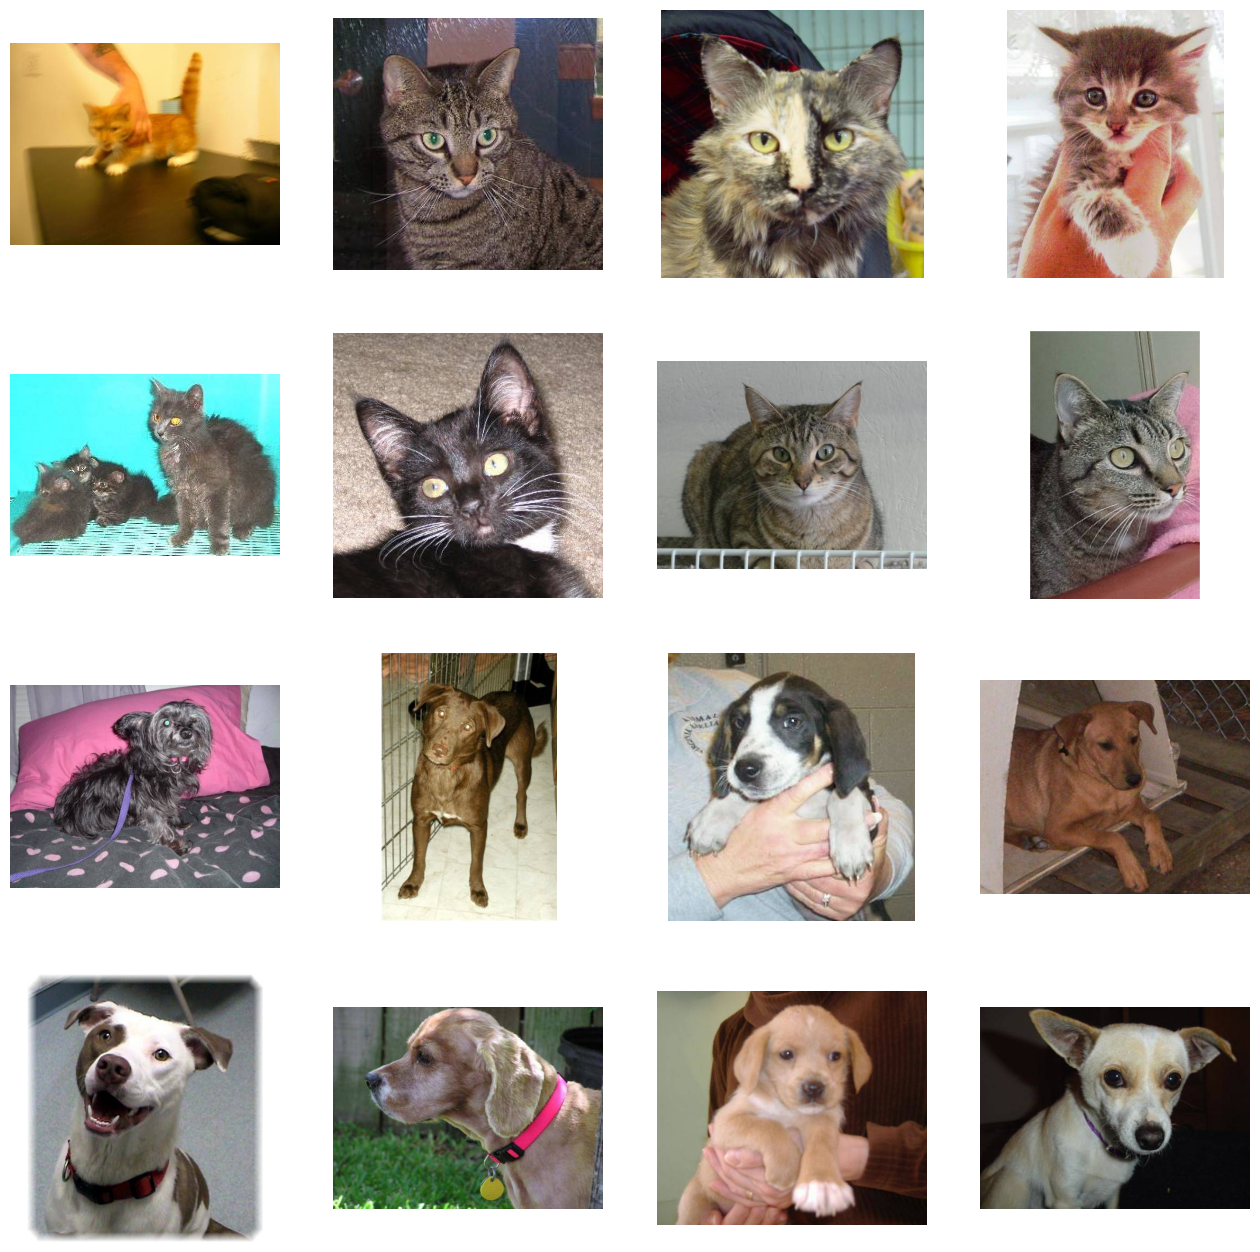

In [14]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = './dataset_tarea_1_2023'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 738 images belonging to 2 classes.


# 2. Modelo CNN (con summary + compile)

In [17]:
# 2. Modelo CNN (con summary + compile)
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions


# Create InceptionV3 base model with pre-trained weights on ImageNet
base_model = InceptionV3(input_shape=(256, 256, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: cat and dog
])

# Display model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 22852898 (87.18 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


# 3. Entrenamiento del modelo (.fit) y rendimiento del modelo (accuracy) con conjunto test

In [18]:
import datetime
#PARA TENSORBOARD

#%tensorboard --reload_interval
#%tensorboard --reload_multifile True
#%reload_ext tensorboard 

#para guardar el aprendizaje y verlo en tensorboard
log_dir = "logs/fitinceptionv3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



# 3. Entrenamiento del modelo (.fit) y rendimiento del modelo (accuracy) con conjunto test
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]  # callback a TensorBoard
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/5
63/63 [==============================] - 128s 2s/step - loss: 0.2009 - accuracy: 0.9395 - val_loss: 0.0311 - val_accuracy: 0.9920
Epoch 2/5
63/63 [==============================] - 117s 2s/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.0385 - val_accuracy: 0.9900
Epoch 3/5
63/63 [==============================] - 118s 2s/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0747 - val_accuracy: 0.9830
Epoch 4/5
63/63 [==============================] - 117s 2s/step - loss: 0.0398 - accuracy: 0.9885 - val_loss: 0.0274 - val_accuracy: 0.9910
Epoch 5/5
24/24 [==============================] - 52s 2s/step - loss: 0.2542 - accuracy: 0.9377
Test Accuracy: 0.9376693964004517


# 4. Trabajo adicional (Neural Transfer, Fine Tuning, visualización de capas intermedias ...)

1/1 [==============================] - 0s 94ms/step


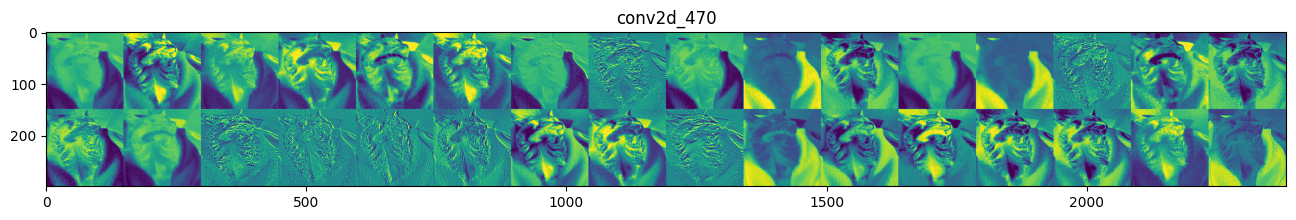

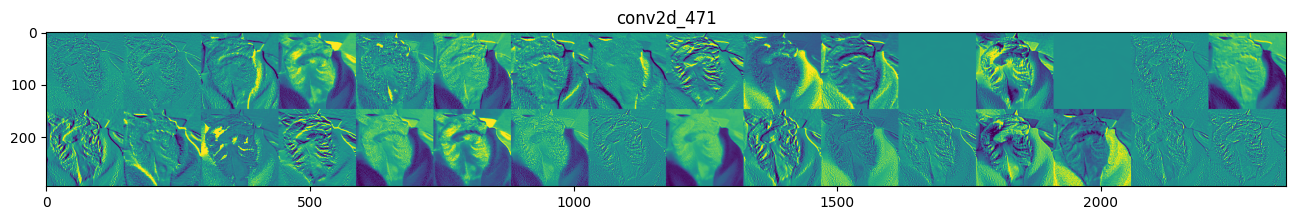

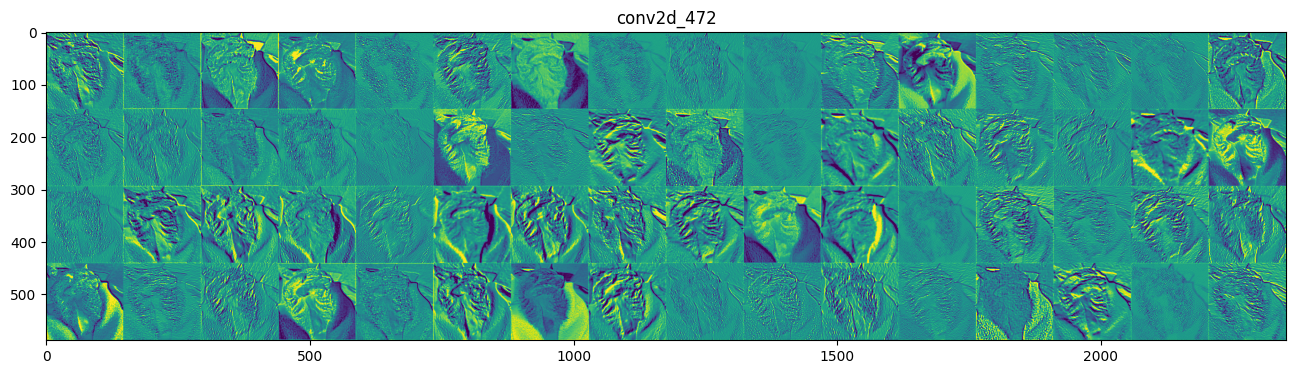

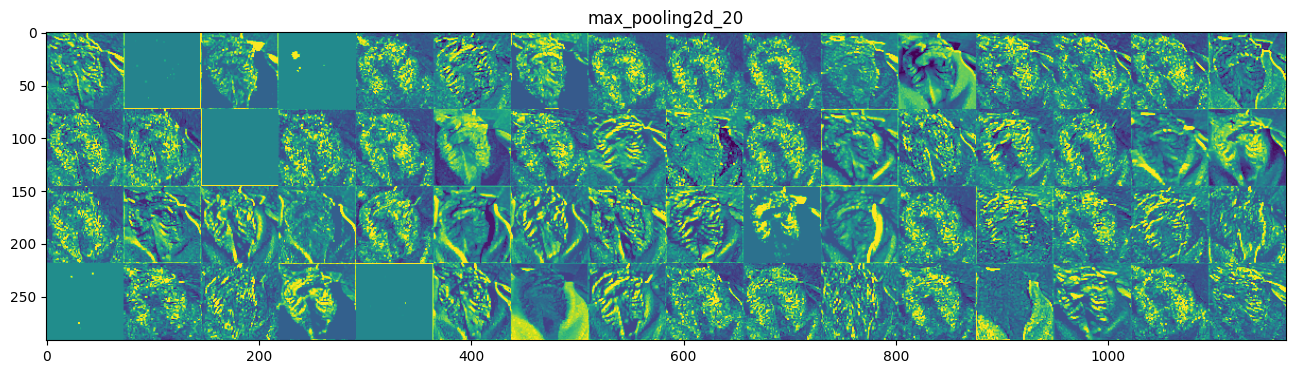

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

# Load the InceptionV3 model with pre-trained weights on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=True)

# Print the names and indices of the layers in the model
#for i, layer in enumerate(base_model.layers):
#    print(f"Layer {i}: {layer.name}")

# Specify the indices of the layers you want to visualize
layer_indices_to_visualize = [1, 4, 7, 10]  # Adjust these indices based on your needs

# Define a new model that outputs the intermediate layers' activations
layer_names = [base_model.layers[i].name for i in layer_indices_to_visualize]
activation_model = Model(inputs=base_model.input, outputs=[base_model.get_layer(layer_name).output for layer_name in layer_names])

# Select a test image
img_path = 'C:/Users/alvar/AppData/Local/Programs/Python/Python311/IA/practica/dataset_tarea_1_2023/test/cats/Foto29.jpeg'  # Change this with the path to a test image
img = image.load_img(img_path, target_size=(299, 299))  # InceptionV3 input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Get activations of the intermediate layers for the test image
activations = activation_model.predict(img_array)

# Visualize the activations
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]

            # Post-process the channel image
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std() + 1e-5
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

    # Check for constant values
    if np.all(display_grid == display_grid[0, 0]):
        continue

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Show the plots
plt.show()


In [ ]:
#5 ES UN GATO O UN PERRO?

1/1 [==============================] - 0s 74ms/step
Prediction: Cat


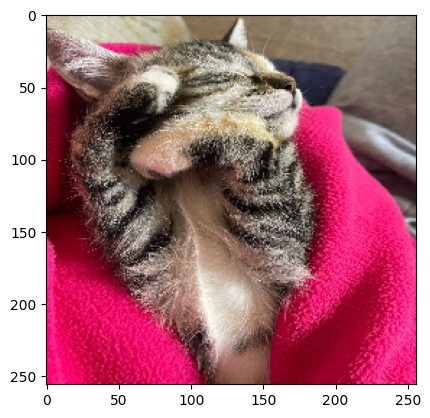

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
def predict_image(model, img_array):
    return model.predict(img_array)

# Realizar predicción en una imagen de prueba
img_path = 'C:/Users/alvar/AppData/Local/Programs/Python/Python311/IA/practica/dataset_tarea_1_2023/test/cats/Foto29.jpeg'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
predictions = predict_image(model, img_array)
label = "Cat" if predictions[0][0] > 0.5 else "Dog"
print(f"Prediction: {label}")
plt.imshow(img)
plt.show()
